## 贝叶斯理论
在我们有一堆样本（包含特征和类别）的时候，我们非常容易通过统计得到P(特征|类别)  
其公式如下：$$ P(x)P(y|x) = P(y)P(x|y) $$  
做下变换：  
$$ P(特征)P(类别|特征) = P(类别)P(特征|类别)$$  
$$ P(类别|特征)=\frac{P(类别)P(特征|类别)}{P(特征)} $$

## 独立假设
实际上，特征可能有很多维  
$$P(features|class) = P(f_0,f_1,...,f_n|c) $$  
若假设两个维度，可以简单写成：  
$$ P(f_0,f_1|c)=P(f_1|c,f_0)P(f_0|c) $$  
这时候我们加一个很牛逼的假设：特征之间的独立的，这样就得到：  
$$ P(f_0,f_1|c)=P(f_1|c)P(f_0|c) $$  
其实也就是：
$$ P(f_0,f_1,...,f_n|c)=\prod_i^nP(f_i|c) $$

## 贝叶斯分类器
回到机器学习，其实我们就是对每个类别计算一个概率P(c_i)，然后在计算所有特征的条件概率P(f_i|c_i)，那么分类的时候我们就是依据贝叶斯找一个最可能的类别：  
$$ P(class_i|f_0,f_1,...,f_n)=\frac{P(class_i)}{P(f_0,f_1,...,f_n)}\prod_j^nP(f_i|c_i) $$

### 文本分类问题
下面我们来看一个文本分类问题，经典的新闻主题分类，用朴素贝叶斯怎么做

In [58]:
# coding:utf-8
import os
import time
import random
import jieba    # 处理中文
import nltk     # 处理英文
import sklearn
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

In [101]:
# 粗暴的词去重
def make_word_set(words_file):
    words_set = set()
    with open(words_file, 'r',encoding='utf-8') as fp:
        for line in fp.readlines():
            word = line.strip()
            if len(word)>0 and word not in words_set:  # 去重
                words_set.add(word)
    return words_set

In [96]:
# 文本处理，也就是样本生成过程
def text_processing(folder_path, test_size=0.2):
    folder_list = os.listdir(folder_path)
    data_list = []
    class_list = []
    
    # 遍历文件夹
    for folder in folder_list:
        new_folder_path = os.path.join(folder_path, folder)
        files = os.listdir(new_folder_path)
        # 读取文件
        j = 1
        for file in files:
            if j>100:  # 怕内存爆掉，只取100个样本
                break
            with open(os.path.join(new_folder_path,file), 'r', encoding='utf-8') as fp:
                raw = fp.read()
                
            # 使用jieba中文分词
            #jieba.enable_parallel(4)    # 开启并行分词模式，参数为并行进程数，不支持windows
            word_cut = jieba.cut(raw, cut_all=False) # 精确输出，返回的结构是一个可迭代的genertor
            word_list =  list(word_cut)  # genertor转化为list，每个词unicode模式
            #jieba.disable_parallel()  # 关闭并行分词模式
            
            data_list.append(word_list)  # 训练集list
            class_list.append(str(folder))  # 类别
            j += 1
            
    # 粗暴地划分训练集和测试集
    data_class_list = list(zip(data_list, class_list))
    random.shuffle(data_class_list)
    index = int(len(data_class_list)*test_size) + 1
    train_list =  data_class_list[index:]
    test_list = data_class_list[:index]
    train_data_list, train_class_list = zip(*train_list)
    test_data_list, test_class_list = zip(*test_list)
        
    # 统计词频放入all_words_dict
    all_words_dict = {}
    for word_list in train_data_list:
        for word in word_list:
            if word in all_words_dict:
                all_words_dict[word] += 1
            else:
                all_words_dict[word] = 1
                    
    # key函数利用词频进行降序排列，内建函数sorted参数需为list
    all_words_tuple_list = sorted(all_words_dict.items(), key=lambda f:f[1], reverse=True)
    all_words_dict,num_list = zip(*all_words_tuple_list)
        
    return all_words_dict, train_data_list, test_data_list, train_class_list, test_class_list

In [103]:
def words_dict(all_words_list, deleteN, stopwords_set=set()):
    # 选取词特征
    feature_words = []
    n = 1
    for t in range(deleteN, len(all_words_list), 1):
        if n > 1000:  # features_words的维度为1000
            break
            
        if not all_words_list[t].isdigit() \
        and all_words_list[t] not in stopwords_set and 1<len(all_words_list[t])<5:
            feature_words.append(all_words_list[t])
            n += 1
    return feature_words

In [62]:
# 文本特征
def text_featrues(train_data_list, test_data_list, feature_words, flag='nltk'):
    def text_featrues(text, feature_words):
        text_words = set(text)
        
        if flag == 'nltk':
            # nltk特征dict
            features = {word:1 if word in text_words else 0 for word in feature_words}
        elif flag == 'sklearn':
            # sklearn特征 list
            features = [1 if word in text_words else 0 for word in feature_words]
        else:
            features = []
            
        return features
    
    train_feature_list = [text_featrues(text, feature_words) for text in train_data_list]
    test_featrue_list = [text_featrues(text, feature_words) for text in test_data_list]
    return train_feature_list, test_featrue_list

In [63]:
# 分类，同时输出准确率等
def text_classifier(train_feature_list, test_feature_list,
                    train_class_list, test_class_list, flag='nltk'):
    if flag == 'nltk':
        # 使用nltk分类器
        train_flist = zip(train_feature_list, train_class_list)
        test_flist = zip(test_feature_list, test_class_list)
        classifier = nltk.classify.NaiveBayesClassifier.train(train_flist)
        test_accuracy = nltk.classify.accuracy(classifier, test_flist)
    elif flag == 'sklearn':
        # sklearn 分类器
        classifier = MultinomialNB().fit(train_feature_list, train_class_list)
        test_accuracy = classifier.score(test_feature_list, test_class_list)
    else:
        test_accuracy = []
        
    return test_accuracy
    

start!
[0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.79, 0.68, 0.74, 0.79, 0.74, 0.79, 0.79, 0.79, 0.79, 0.74, 0.74, 0.79, 0.79, 0.74, 0.74, 0.79, 0.79, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.58, 0.58, 0.58, 0.58, 0.63, 0.58, 0.58]


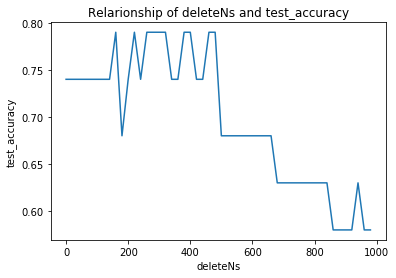

finished!


In [106]:
print('start!')

# 文本预处理
folder_path = 'Database/SogouC/Sample'
all_words_list, train_data_list, test_data_list, train_class_list, test_class_list = text_processing(folder_path, 0.2)

# 生成stopwords_set
stopwords_file = 'stopwords_cn.txt'
stopwords_set = make_word_set(stopwords_file)

# 文本特征提取和分类
flag = 'sklearn'
deleteNs = range(0, 1000, 20)
test_accuracy_list = []

for deleteN in deleteNs:
    feature_words = words_dict(all_words_list, deleteN, stopwords_set)
    train_feature_list, test_feature_list = text_featrues(train_data_list, test_data_list,
                                                         feature_words, flag)
    test_accuracy = text_classifier(train_feature_list, test_feature_list,
                                    train_class_list, test_class_list, flag)
    test_accuracy_list.append(round(test_accuracy,2))
print(test_accuracy_list)

# 结果评价
plt.plot(deleteNs, test_accuracy_list)
plt.title('Relarionship of deleteNs and test_accuracy')
plt.xlabel('deleteNs')
plt.ylabel('test_accuracy')
plt.show()

print('finished!')